In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt

filepath = './sunspot.txt'

data = pd.read_csv(filepath, sep=' ', skipinitialspace=True, index_col = 0, header=None) #parse_dates=[0]

stack = data.stack()

new_index=stack.index.map(lambda x: datetime.datetime(x[0],x[1],1,0,0))
data = pd.Series(stack.values, index=new_index.values)

data.index.name = 'date'

test = data.iloc[data.index.get_loc('2010-01-01')-20:-1]
train = data[:'2009']

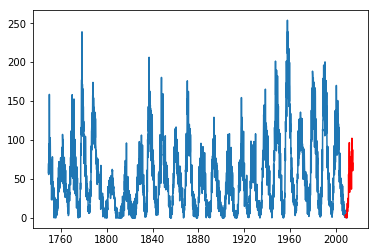

In [2]:
%matplotlib inline
plt.plot(train)
plt.plot(test, color='red')
plt.show()

In [3]:
data_array = train.values
# https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/
def series_to_supervised(data_array, K=1):
    X = np.array([])
    Y = np.array([])

    for i in range(len(data_array)-K):
        X = np.append(X, data_array[i:K+i])
        Y = np.append(Y, data_array[K+i])
    X = X.reshape((-1,K))
    return (X, Y)

X_train, Y_train = series_to_supervised(train.values, 20)
X_test, Y_test = series_to_supervised(test.values, 20)

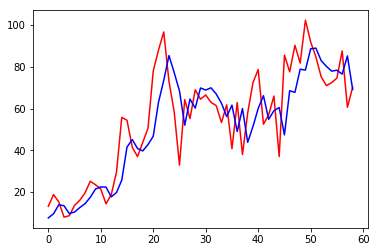

Mean Squared Error: 212.263723 
R2: 0.670314


In [4]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

lr = LinearRegression(fit_intercept=False)
lr = lr.fit(X_train, Y_train)

y_pred = lr.predict(X_test)

%matplotlib inline
# plt.figure(1)
plt.plot(Y_test, color='red')
plt.plot(y_pred, color='blue')
plt.show()

print("Mean Squared Error: %f \nR2: %f" % (mean_squared_error(Y_test,y_pred), r2_score(Y_test,y_pred)))


## (b)

1. Starting with K=20 and do a k-fold division of training data
1. Using a wrapper strategy find the better set of variables to predict the data
1. Use Ridge Regression to predict
1. Use RMSE to compair the performance

In [5]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Ridge

ALPHA_LIST = [1e-15, 1e-10, 1e-8, 1e-4, 1e-3,1e-2, 1, 5, 10, 20]
N_OF_VARIABLES = 20

np.random.seed(42)
perm_array = np.random.permutation(len(Y_train)) # for permute the training dataset
kf = KFold(n_splits=5)


starting_variables = [i for i in range(N_OF_VARIABLES)]

all_results = {}
while len(starting_variables)>1:
    variables = starting_variables[:]
    n_var = len(variables) - 1
    for i in range(n_var):
        v = variables[:]
        out_variable = v.pop(i)
        error = []
        # Find the best alpha in a list for Ridge Regression
        for alpha in ALPHA_LIST:
            lrr = Ridge(alpha=alpha)
            error_kf=set()
            for train, test in kf.split(X_train):
                lrr.fit(X_train[perm_array][train][:,v],Y_train[perm_array][train])
                error_kf.add(mean_squared_error(Y_train[perm_array][test],lrr.predict(X_train[perm_array][test][:,v])))
            error.append({'mean':min(error_kf), 'alpha':alpha})
        if n_var not in all_results:
            all_results[n_var] = [{
                "error": min(error, key=lambda x:x['mean']), 
                "variables": v[:],
                "out_variable" : out_variable
            }]
        else:
            all_results[n_var].append({
                "error": min(error, key=lambda x:x['mean']), 
                "variables": v[:],
                "out_variable" : out_variable
            })
    worst_with_k_varibles = max(all_results[n_var], key=lambda x:x['error']['mean'])
    starting_variables.remove(worst_with_k_varibles['out_variable'])

In [6]:
# min(all_results[5], key=lambda x:x['error']['mean'])
print("\tError\t\tVariables")
min_var=[]
for n_var in all_results:
    min_var_ = min(all_results[n_var], key=lambda x:x['error']['mean'])
    min_var.append(min_var_)
    print("\t%f\t%.1e\t%s" % (min_var_['error']['mean'], min_var_['error']['alpha'],min_var_['variables']))
# min_var
best_predictor = min(min_var, key=lambda x: x['error']['mean'])
print("\n\nBest Predictor at train dataset\nError:\t%f\nVariables:\t%s\nalpha:\t%.1e" % (best_predictor['error']['mean'], best_predictor['variables'], best_predictor['error']['alpha']))

	Error		Variables
	205.277555	2.0e+01	[0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
	207.758195	2.0e+01	[0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19]
	212.337928	1.0e-15	[0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 19]
	215.836779	2.0e+01	[0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 19]
	218.993082	2.0e+01	[0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 19]
	223.506618	2.0e+01	[0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 19]
	226.619381	2.0e+01	[0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 19]
	227.397696	2.0e+01	[0, 1, 3, 4, 5, 7, 8, 9, 10, 11, 12, 19]
	227.948271	2.0e+01	[0, 1, 3, 4, 5, 7, 8, 9, 10, 11, 19]
	234.008396	1.0e-15	[0, 1, 2, 4, 5, 7, 8, 9, 10, 19]
	235.102656	1.0e-15	[0, 1, 2, 4, 7, 8, 9, 10, 19]
	235.905120	1.0e-15	[0, 1, 2, 4, 7, 9, 10, 19]
	236.888533	2.0e+01	[0, 1, 3, 4, 7, 10, 19]
	240.743258	1.0e-15	[0, 1, 2, 4, 7, 19]
	243.552437	1.0e-15	[0, 1, 2, 4, 19]
	244.628265	1.0e-15	[0, 1, 2, 19]
	244.596953	1.0e-15	[0, 1, 

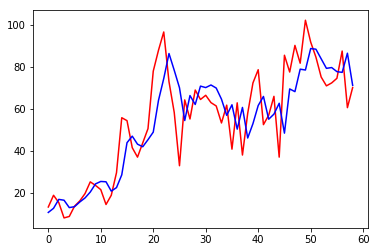

Mean Squared Error: 206.248730 
R2: 0.679656


In [8]:
# best_predictor
lrr = Ridge(alpha=best_predictor['error']['alpha'])
lrr.fit(X_train[:,best_predictor['variables']],Y_train)

y_pred = lrr.predict(X_test[:,best_predictor['variables']])

%matplotlib inline
# plt.figure(1)
plt.plot(Y_test, color='red')
plt.plot(y_pred, color='blue')
plt.show()


print("Mean Squared Error: %f \nR2: %f" % (mean_squared_error(Y_test,y_pred), r2_score(Y_test,y_pred)))
